In [15]:
!pip install tinymlgen
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tinymlgen import port
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping



In [27]:
# Carico il dataset (session storage)
df = pd.read_csv("dati_ormeggio_etichettati.csv")

print("Colonne presenti nel dataset:", df.columns.tolist())

# Distinzione delle colonne
FEATURES = ['Accelerometro_X', 'Accelerometro_Y', 'Accelerometro_Z',
            'Giroscopio_X', 'Giroscopio_Y', 'Giroscopio_Z', 'Solcometro']
TARGET = "Ormeggio"

# Conversione in array
X = df[FEATURES].values
y = df[TARGET].values

# Normalizzazione dei dati (media e dev. stand.)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#(righe, colonne)
print(f"Shape X_scaled: {X_scaled.shape}")


Colonne presenti nel dataset: ['Accelerometro_X', 'Accelerometro_Y', 'Accelerometro_Z', 'Giroscopio_X', 'Giroscopio_Y', 'Giroscopio_Z', 'Solcometro', 'Ormeggio']
Shape X_scaled: (20000, 7)


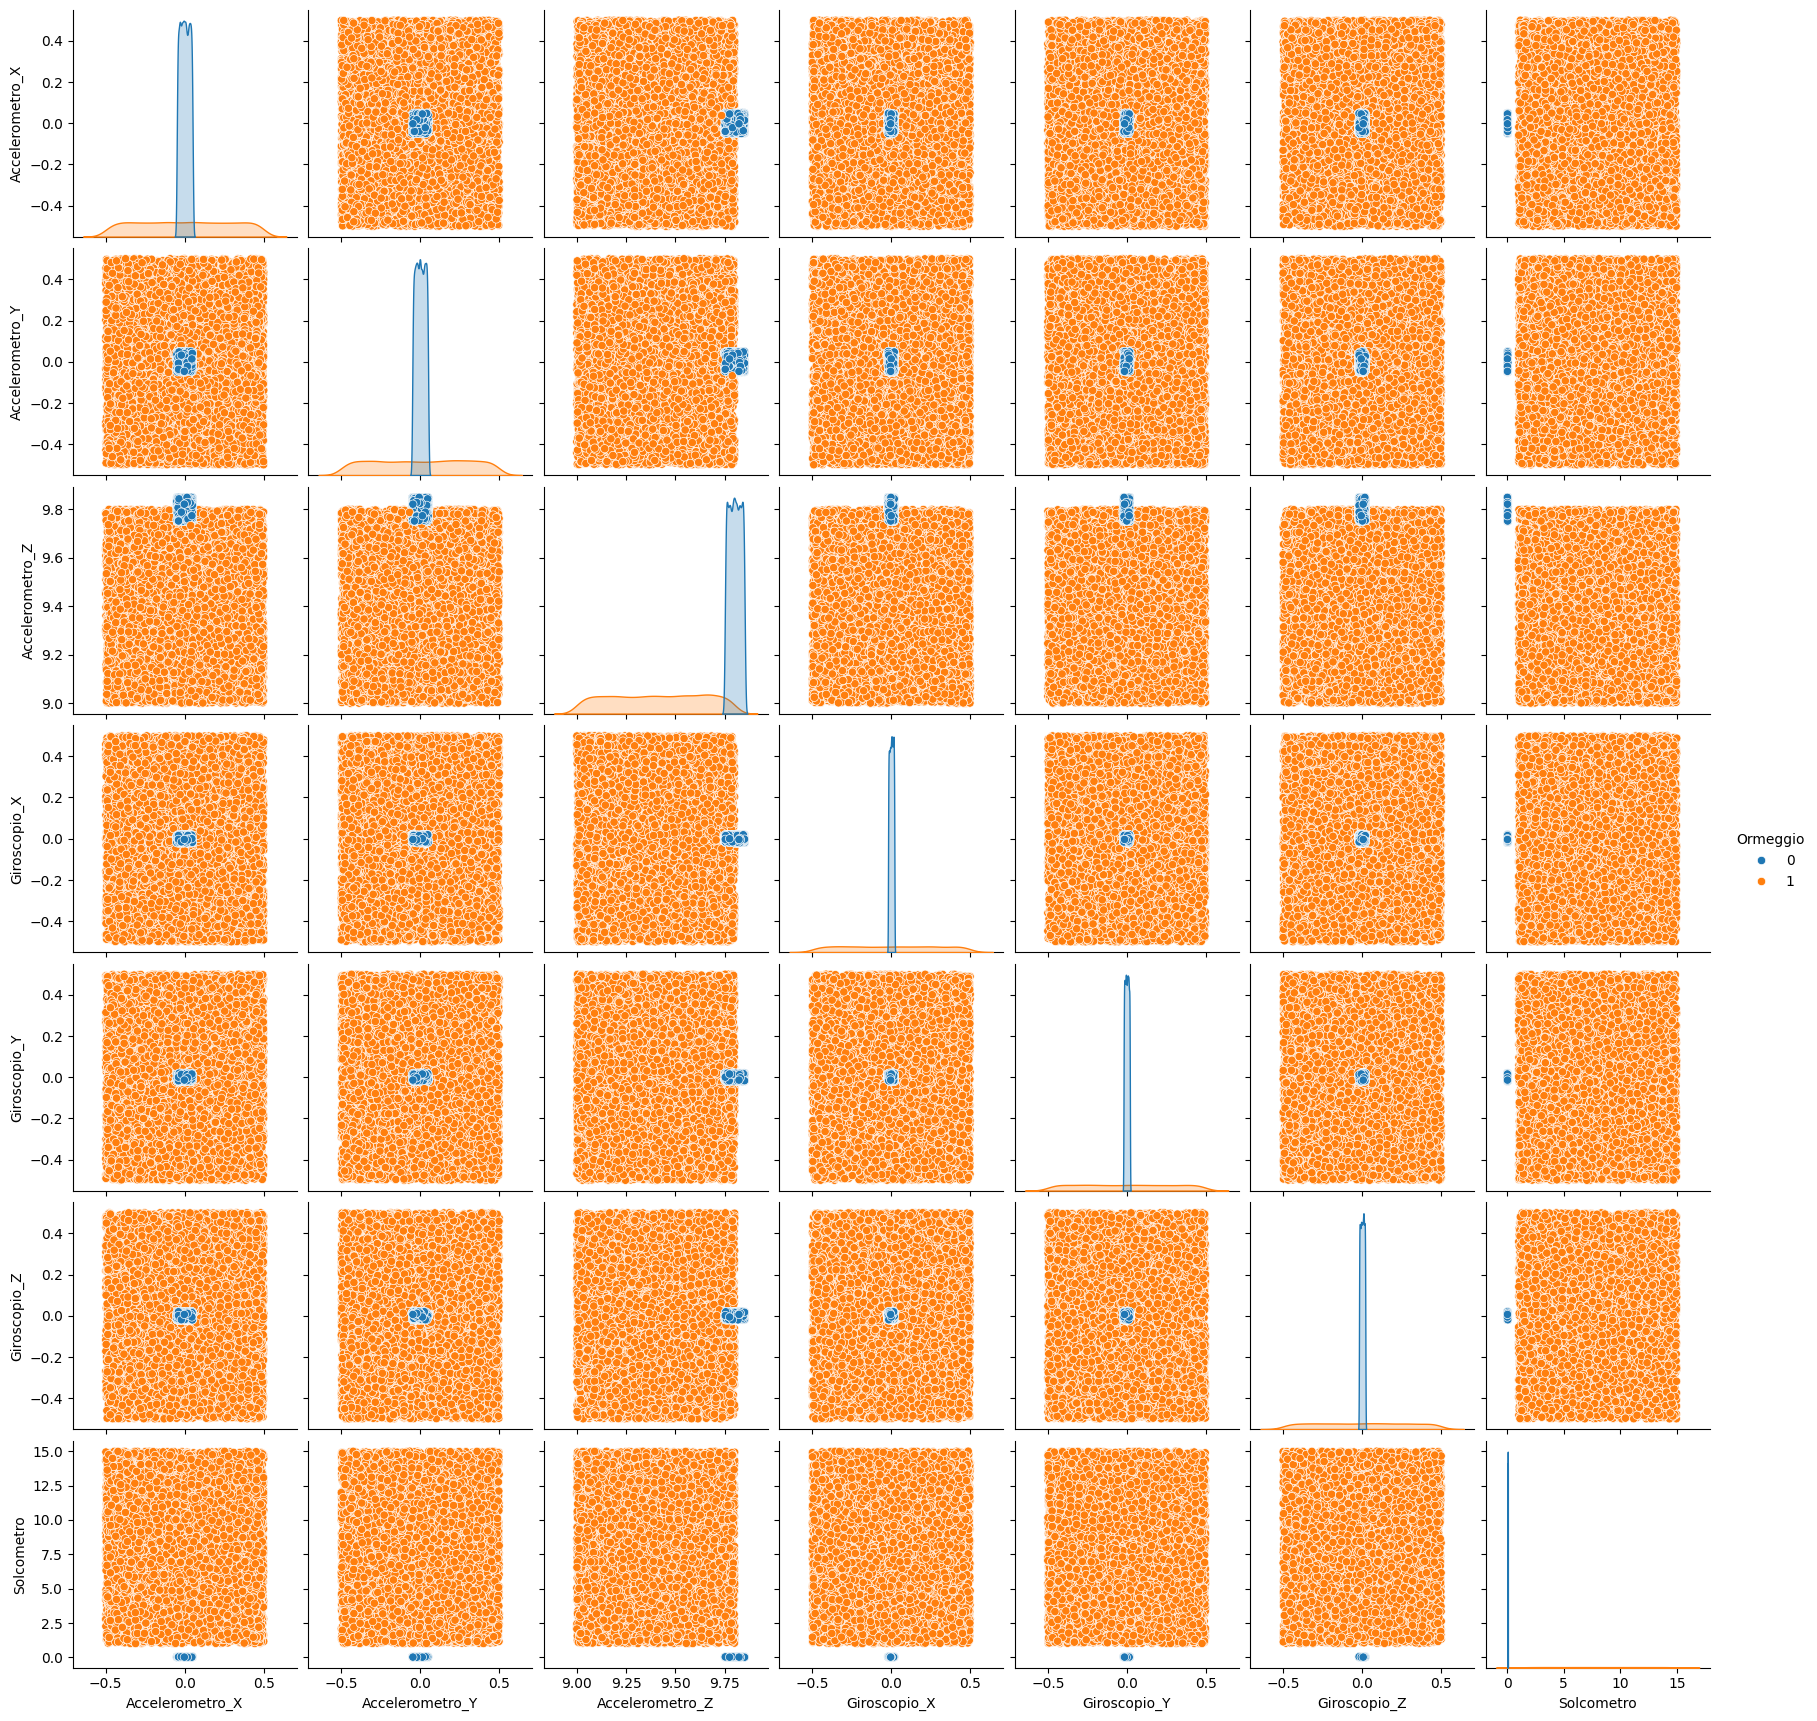

In [3]:
# Capire la distribuzione dei dati
sns.pairplot(df, hue="Ormeggio", diag_kind="kde")
plt.show()


In [31]:
# Suddivisione in traning e test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

X_train_noisy = X_train + np.random.normal(0, 0.02, X_train.shape)

# Controllo finale
print(f"Shape X_train: {X_train.shape}, Shape X_test: {X_test.shape}")



Shape X_train: (14000, 7), Shape X_test: (6000, 7)


In [35]:

# Early stop per fermare automaticamente il traning

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Creazione della rete
model = keras.Sequential([
    keras.layers.Dense(6, activation='relu', input_shape=(7,)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compilazione del modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(
    X_train_noisy, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)



Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3250 - loss: 0.7466 - val_accuracy: 0.8003 - val_loss: 0.5350
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8093 - loss: 0.5258 - val_accuracy: 0.9435 - val_loss: 0.3831
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9138 - loss: 0.3930 - val_accuracy: 0.9818 - val_loss: 0.2525
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9466 - loss: 0.2761 - val_accuracy: 0.9942 - val_loss: 0.1434
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9532 - loss: 0.1958 - val_accuracy: 0.9975 - val_loss: 0.0798
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9635 - loss: 0.1399 - val_accuracy: 0.9972 - val_loss: 0.0483
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9725 - loss: 0.1079 - val_accuracy: 0.9982 - val_loss: 0.0321
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9770 - loss: 0.0886 - val_accuracy: 0.

In [37]:
# Valutazione delle prestazioni
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy sul test set: {accuracy:.2f}')


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0049
Accuracy sul test set: 1.00


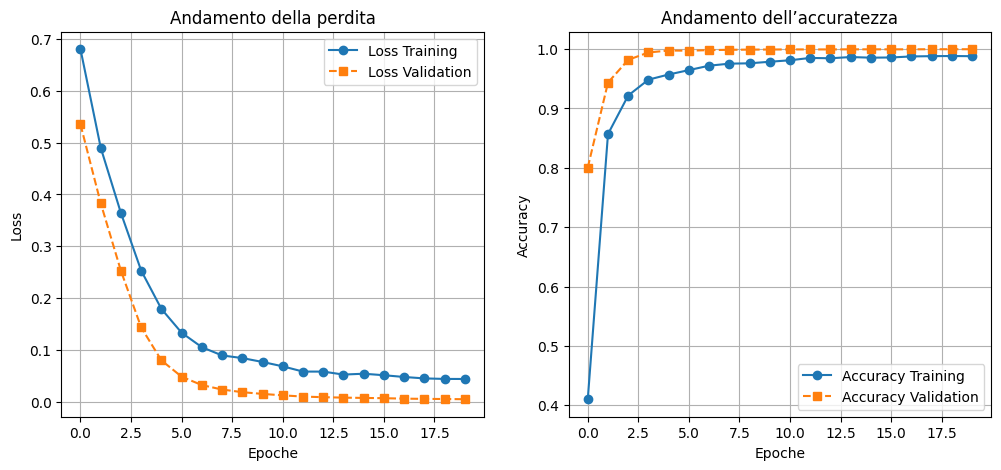

In [38]:

# Grafico della perdita e dell'accuratezza
plt.figure(figsize=(12, 5))

# Andamento della perdita (loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss Training', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Loss Validation', linestyle='--', marker='s')
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.legend()
plt.title("Andamento della perdita")
plt.grid(True)

# Andamento dell'accuratezza (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy Training', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Accuracy Validation', linestyle='--', marker='s')
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Andamento dell’accuratezza")
plt.grid(True)

plt.show()


In [39]:
# Conversione del modello
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

c_code = port(model,
              pretty_print=True,
              variable_name='ormeggio_model')

# Lo salvo in un file .h
with open("ormeggio_model.h", "w") as f:
    f.write(c_code)

print("Modello esportato con successo")




Saved artifact at '/tmp/tmpxjk1_1ya'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='keras_tensor_58')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133952199370960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133952199364624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133952199366544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133952199367888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133952199372880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133952199365776: TensorSpec(shape=(), dtype=tf.resource, name=None)


Saved artifact at '/tmp/tmpn_zs842i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='keras_tensor_58')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133952199370960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133952199364624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133952199366544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133952199367888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133952199372880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133952199365776: TensorSpec(shape=(), dtype=tf.resource, name=None)


Modello esportato con successo
